In [3]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

sys.path.append("../scripts")
sys.path.append("..")

from extract import *

In [4]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)

table = read_table(path)
N2 = extract_node(table,'N2')
T  = extract_node(table,'T')
S  = extract_node(table,'S')
Z  = extract_node(table,'z').flatten()

#Compute the mean stratification
DSL = slice(15,75) # depth slice
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean[DSL],T_mean[DSL],2000)
#R_mean  = sw.eos80.pden(S_mean[DSL],T_mean[DSL],Z[DSL],pr=2000)


#Define a slice
sl = (slice(0,-1),DSL,slice(0,-1),slice(0,-1))

#Subsample matrices
TP = T[sl]
SP = S[sl]
NP = N2[sl]

TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

t0 = matlab2datetime(TIME[0]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0)/3600 for T in TIME]


#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,LAT,LON])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(TP.shape)


In [5]:
#Compute Density from state variables
RP = sw.eos80.dens(SP,TP,2000)
#RP = sw.eos80.pden(SP,TP,AX['z'],pr=2000)
RDIF = np.zeros(shape=RP.shape) 
for i in range(RP.shape[0]-1):
    for j in range(RP.shape[2]-1):
        for k in range(RP.shape[3]-1):
            RDIF[i,:,j,k] = RP[i,:,j,k] - R_mean
       
            
#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z[DSL])
DZ   = AX['z'] - zofr(RP) 
    
    
#Place an M2 band pass filter
def bandpass_filter(center,half_width,fs,order=5):
    nyq = fs*0.5
    lo = (center-half_width/nyq)
    hi = (center+half_width/nyq)
    b, a = sig.butter(order, [lo, hi], btype='band')
    return b,a

M2  = .0805 
bw  = .01
b,a = bandpass_filter(M2,bw,1)
DZB = sig.lfilter(b,a,DZ,axis=0)
RPB = sig.lfilter(b,a,RP,axis=0)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


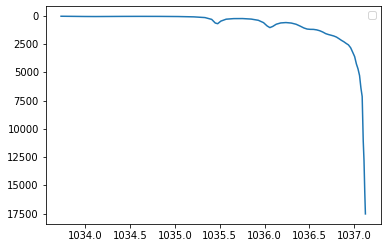

In [608]:
%matplotlib widget
zofr_p = zofr.derivative()
#plt.plot(R_mean,Z[DSL],'b.',  label='Density w/o PT',)
#plt.plot(R_mean_P,Z[DSL],'r.', label='Density w/ PT',)
#plt.plot(R_mean_P,zofr(R_mean_P))
plt.plot(R_mean_P[:-1],zofr_p(R_mean_P[:-1]))
plt.gca().invert_yaxis()
plt.legend()

(2000, 5)


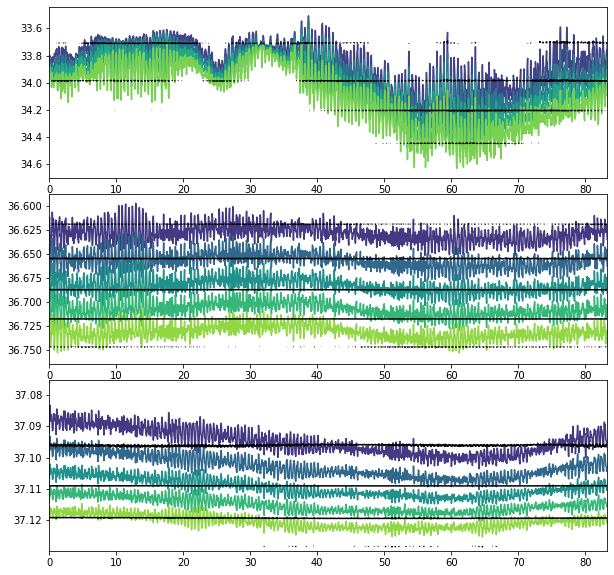

In [38]:
import matplotlib as mpl
f =  plt.figure()
gs = mpl.gridspec.GridSpec(ncols=1,nrows=6,figure=f)
ax0 = f.add_subplot(gs[0:2,0])
ax1 = f.add_subplot(gs[2:4,0])
ax2 = f.add_subplot(gs[4:6,0])
s1 = (slice(0,2000),slice(0,4),2,1)
s2 = (slice(0,2000),slice(35,40),2,1)
s3 = (slice(0,2000),slice(-6,-1),2,1)
ax0.contour(AX[s1]['t']/24,RP[s1]-1000,AX[s1]['z'],levels=4)
ax0.contour(AX[s1]['t']/24,RP[s1]-1000,zofr(RP[s1]),levels=4,colors='k')

ax1.contour(AX[s2]['t']/24,RP[s2]-1000,AX[s2]['z'],levels=5)
ax1.contour(AX[s2]['t']/24,RP[s2]-1000,zofr(RP[s2]),levels=5,colors='k')

ax2.contour(AX[s3]['t']/24,RP[s3]-1000,AX[s3]['z'],levels=5)
ax2.contour(AX[s3]['t']/24,RP[s3]-1000,zofr(RP[s3]),levels=5,colors='k')
#p = ax1.contourf(AX[s2]['t'],np.tile(R_mean[55:59],(200,1)),np.tile(Z[55:59],(200,1)),levels=10)


#p=ax.contourf(AX[s]['t'],RP[s],AX[s]['z'],levels=50,cmap='jet')
#p=ax.contourf(AX[s]['t'],AX[s]['z'],np.tile(R_mean[s[1]],(700,1)),levels=20)
ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
#f.colorbar(p)
#f.autofmt_xdate(rotation=70)
f.set_size_inches(10,10)
print(RP[s2].shape)

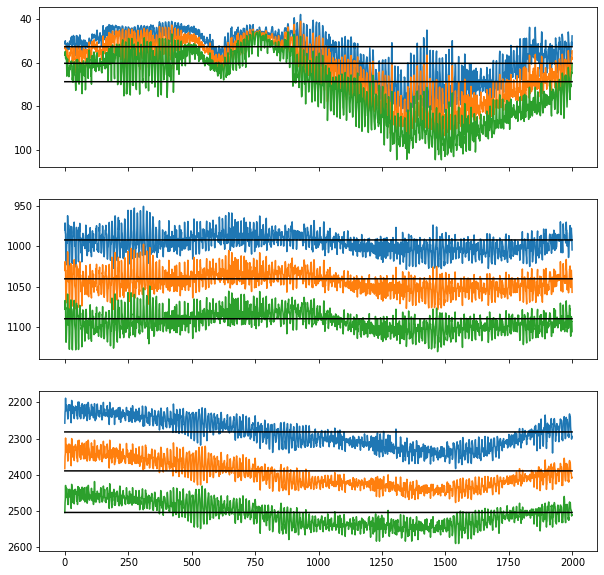

In [33]:
f , ax = plt.subplots(3,1,sharex=True)
ax[0].plot(zofr(RP[s1][:,1:4]))
ax[0].plot(AX[s1]['z'][:,1:4],'k-')

ax[1].plot(zofr(RP[s2][:,1:4]))
ax[1].plot(AX[s2]['z'][:,1:4],'k-')

ax[2].plot(zofr(RP[s3][:,1:4]))
ax[2].plot(AX[s3]['z'][:,1:4],'k-')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

f.set_size_inches(10,10)

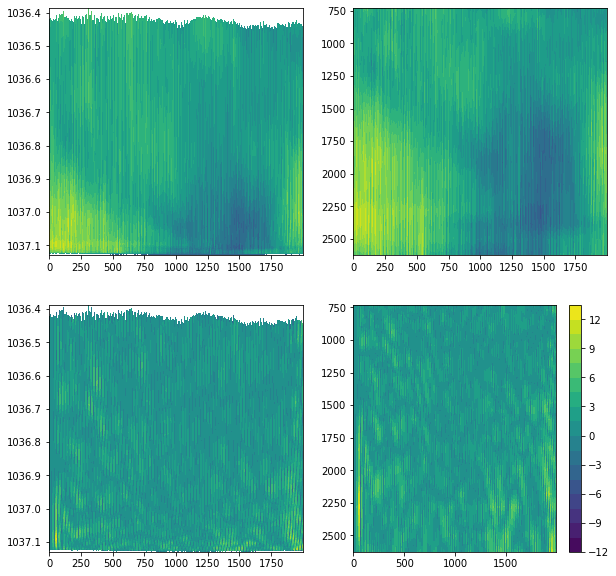

In [6]:
f,ax = plt.subplots(2,2)
s = (slice(0,2000),slice(30,-1),2,1)
p=ax[0,0].contourf(AX[s]['t'],RP[s],DZ[s],levels=20)
p=ax[0,1].contourf(AX[s]['t'],AX[s]['z'],DZ[s],levels=20)
p=ax[1,0].contourf(AX[s]['t'],RP[s],DZB[s],levels=20)
p=ax[1,1].contourf(AX[s]['t'],AX[s]['z'],DZB[s],levels=20)
#ax.contour(AX[s]['t'],RP[s],DZ[s],levels=20,colors='k')
#p=ax.contourf(AX[s]['t'],AX[s]['z'],np.tile(R_mean[s[1]],(700,1)),levels=20)
#ax.contour(AX[s]['t'],AX[s]['z'],np.tile(R_mean[s[1]],(700,1)),levels=55,colors='w')

ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
f.colorbar(p)
f.set_size_inches(10,10)


In [490]:
total = RDIF[0,:,0,0]+R_mean
AX[0,np.where(total > max(R_mean)),0,0]['z']

array([], shape=(1, 0), dtype=float64)

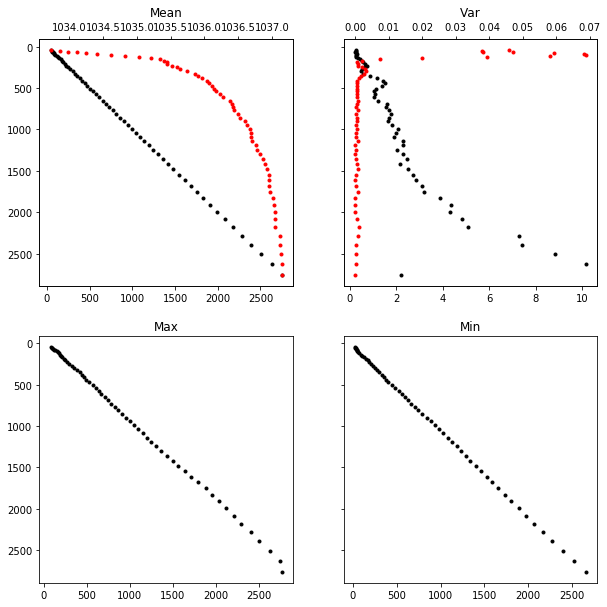

In [35]:
f , ax = plt.subplots(2,2,sharey=True)
ax[0,0].invert_yaxis()
ax[0,0].plot(np.mean(zofr(RP),axis=(0,2,3)),Z[DSL],'k.')
axs0 = ax[0,0].twiny()
axs0.plot(np.mean(RP,axis=(0,2,3)),Z[DSL],'r.')
ax[0,0].set_title("Mean")

ax[0,1].plot(np.var(DZB,axis=(0,2,3)),Z[DSL],'k.')
axs1 = ax[0,1].twiny()
axs1.plot(np.var(RP,axis=(0,2,3)),Z[DSL],'r.')
ax[0,1].set_title("Var")
ax[1,0].plot(np.max(abs(zofr(RP)),axis=(0,2,3)),Z[DSL],'k.')
ax[1,0].set_title("Max")
ax[1,1].plot(np.min(abs(zofr(RP)),axis=(0,2,3)),Z[DSL],'k.')
ax[1,1].set_title("Min")
f.set_size_inches(10,10)

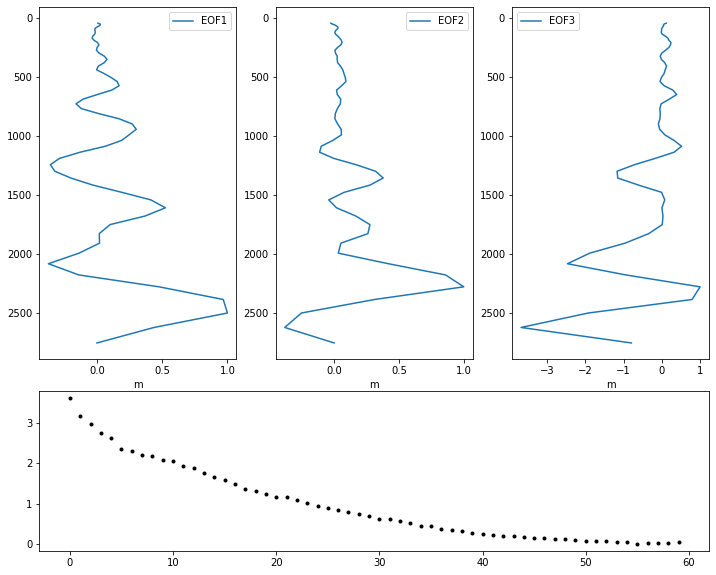

In [425]:
"""
PCA Analysis
"""
%matplotlib inline
import matplotlib as mpl

#Compute and then subtract the mean
DB = np.mean(DZ,axis=(0,2,3))

DZP = np.zeros(shape=DZ.shape)
for i in range(DZ.shape[0]-1):
    for j in range(DZ.shape[2]-1):
        for k in range(DZ.shape[3]-1):
            DZP[i,:,j,k] = DZ[i,:,j,k] - DB

#Stack in time and space
DZPL = []
for i in range(DZ.shape[2]-1):
    for j in range(DZ.shape[3]-1):
            DZPL.append(DZ[:,:,j,k])
            
DZP = np.concatenate(DZPL)

            
R = np.cov(DZP[:,:].T)
w,v  = np.linalg.eig(R)

f  =  plt.figure()
gs = mpl.gridspec.GridSpec(3,3)
for i in range(0,3):
    ax = f.add_subplot(gs[0:2,i])
    ax.plot(v[:,i]/max(v[:,i]),Z[DSL],label='EOF%d' % (i+1))
    ax.set_xlabel("m")
    ax.invert_yaxis()
    ax.legend()

ax = f.add_subplot(gs[2,:])
ax.plot(np.sqrt(w),'k.')
f.set_size_inches(12,10)

(2927, 60) (60, 60)


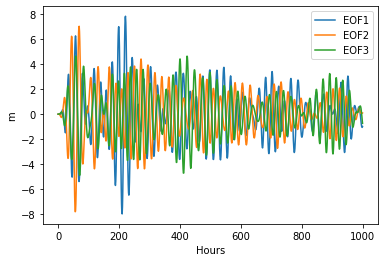

In [427]:
DZP = DZ[:,:,0,0]
print(DZP.shape,v.shape)
u = DZP @ v.T
f , ax = plt.subplots()
ax.plot(u[0:1000,0],label="EOF1")
ax.plot(u[0:1000,1],label="EOF2")
ax.plot(u[0:1000,2],label="EOF3")
ax.set_xlabel("Hours")
ax.set_ylabel("m")
ax.legend()
#ax.plot(DZP[0:200,0])

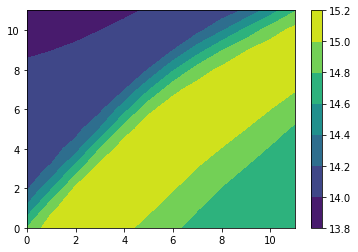

In [398]:
mask = extract_node(table,'mask')
Tm = np.ma.masked_array(T[0,:,:,:],mask=np.isnan(mask))
plt.contourf(Tm[0,:,:])
plt.colorbar()